26029
0
0.1
-0.1
min1:0 max1:255  #  min2:100 max2:157  #   min3:76 max3:191
(160, 320, 3)


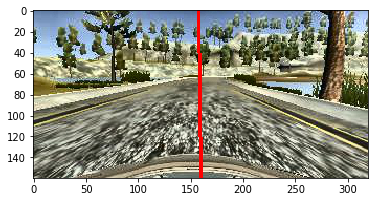

angle:-0.009433962
(66, 200, 3)
(66, 200, 3)


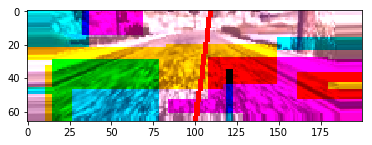

angle:0.14485767043882783
min1:0 max1:255  #  min2:100 max2:157  #   min3:76 max3:191
(160, 320, 3)


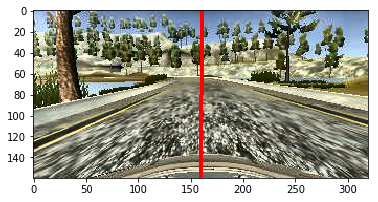

angle:0.009433962
(66, 200, 3)
(66, 200, 3)


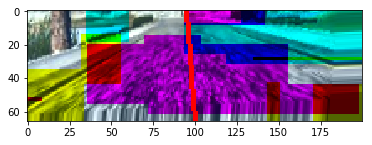

angle:-0.06497311515762716
min1:0 max1:255  #  min2:99 max2:151  #   min3:73 max3:196
(160, 320, 3)


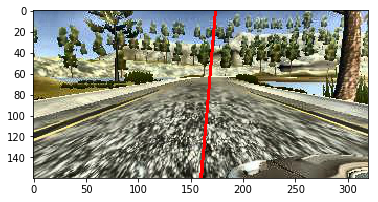

angle:0.090566038
(66, 200, 3)
(66, 200, 3)


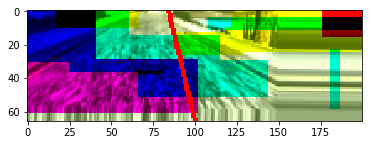

angle:-0.23304152115037613
min1:0 max1:255  #  min2:99 max2:151  #   min3:73 max3:196
(160, 320, 3)


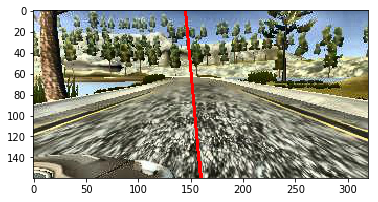

angle:-0.090566038
(66, 200, 3)
(66, 200, 3)


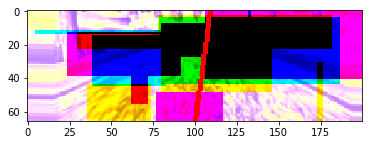

angle:0.14287992101845248
min1:1 max1:255  #  min2:102 max2:154  #   min3:78 max3:207
(160, 320, 3)


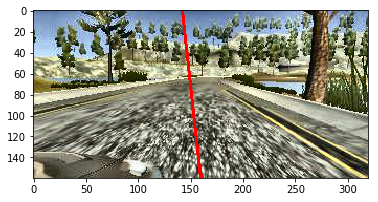

angle:-0.10943396200000001
(66, 200, 3)
(66, 200, 3)


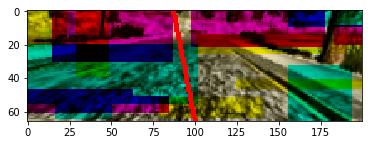

angle:-0.18415461854375278
min1:1 max1:255  #  min2:102 max2:154  #   min3:78 max3:207
(160, 320, 3)


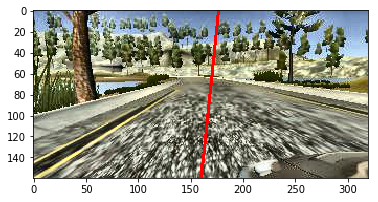

angle:0.10943396200000001
(66, 200, 3)
(66, 200, 3)


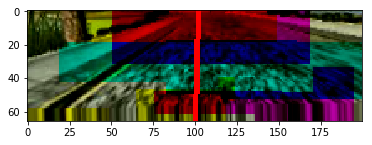

angle:0.0443218454322591


In [277]:
#This notebook is only for analysing the data and test various methods to see that the augumutation is correct

import csv
import numpy as np
import cv2
import sklearn
from sklearn.model_selection import train_test_split

### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def print_img(img,angle):
    shape=np.shape(img)
    print(shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#cv2 is bgr while plotlib do rgb
    #cv2.putText(img, 'angle: ' + str(angle),(20,20),cv2.FONT_HERSHEY_SIMPLEX,(255,255,255),2)
    
    #cv2.line(img, pt1, pt2, color[, thickness[, lineType[, shift]]])
    cv2.line(img,(int(shape[1]/2),int(shape[0])),(int((shape[1]/2)+angle*shape[0]),0),(255,0,0),thickness=2)
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"angle:{angle}")
#use pandas instead?

#if we rotate image, rotate steering at same?

    
def warp_image(image,angle):
    shape=np.shape(image)
    zoomx=np.random.uniform(0.8,1.2)
    #zoomxy=np.random.uniform(-0.2,0.2)
    zoomy=np.random.uniform(0.8,1.2)#zoomx-zoomxy
    zoomxy=zoomx-zoomy
    extrapixelsx=(shape[0]-shape[0]*zoomx)/2
    extrapixelsy=(shape[1]-shape[1]*zoomy)/2
    movex=np.random.uniform(-30,30)
    movey=np.random.uniform(-15,15)
    posx=extrapixelsx+movex/(zoomx*2) 
    posy=extrapixelsy+movey/(zoomy*2)
    skewx=np.random.uniform(-0.1,0.1)
    skewy=np.random.uniform(-0.05,0.05)  ##take it easy with this!
    #print(f"zoomx {zoomx},zoomy {zoomy},movex {movex}, movey {movey}, skewx {skewx}, skewy {skewy}")
    M = np.float32([[zoomx,skewx,posx],[skewy,zoomy,posy]])
    image= cv2.warpAffine(image,M,(shape[1],shape[0]), borderMode=cv2.BORDER_REPLICATE)
    angle+=(skewx*0.5)+(skewy*0.5)+movex/100+zoomxy*angle
    return image, angle

def change_colors_image(image):
    image = image.astype(np.int32)
    sigma=30 ##difference between channels
    mu=np.random.randint(-100,100) #brightness
    rnds = np.round(np.random.normal(mu, sigma, 3)).astype(int)
    for i,r in enumerate(rnds):
        if np.random.rand() < 0.1:
            image[:,:,i]=255-image[:,:,i]
            
        
        image[:,:,i]= np.clip(image[:,:,i] + r,0,255)

    return image.astype(np.uint8)
    
def dropout_image(image):
    shape=np.shape(image)
    #https://github.com/aleju/imgaug
    #Randomly remove parts of the image
    #Similar to dropout in the network, if the network can learn
    #on more limited parts, it should work better!
    for i in range(3):
        for j in range(5):
            center=(np.random.randint(0,shape[0]), np.random.randint(0,shape[1]))
            size=(np.random.randint(0,shape[0]/3), np.random.randint(0,shape[1]/3))
            
            pt1=(np.clip(center[0]-size[0],0,shape[0]),np.clip(center[1]-size[1],0,shape[1]))
            pt2=(np.clip(center[0]+size[0],0,shape[0]), np.clip(center[1]+size[1],0,shape[1]))
            image[pt1[0]:pt2[0],pt1[1]:pt2[1],i]=0

    return image
    
def augument_image(image,angle):
    image,angle=warp_image(image,angle)
    image=change_colors_image(image)
    image=dropout_image(image)
    return image, angle


def rgb_clahe(img):
    #https://stackoverflow.com/questions/24341114/simple-illumination-correction-in-images-opencv-c/24341809#24341809
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    return cv2.merge((cl, a, b))


#########################
#main code:

all_images=True
with open('data/driving_log.csv', 'r') as file:
    samples = [line for line in csv.reader(file, delimiter=',')][1:]
if all_images:
    with open('data/driving_log2.csv', 'r') as file:
        samples2 = [line for line in csv.reader(file, delimiter=',')][1:]

    with open('data/drivinglog_map2.csv', 'r') as file:
        samples3 = [line for line in csv.reader(file, delimiter=',')][1:]

    with open('data/drivinglog_dirt.csv', 'r') as file:
        samples4 = [line for line in csv.reader(file, delimiter=',')][1:]

    with open('data/driving_log_left.csv', 'r') as file:
        samples5 = [line for line in csv.reader(file, delimiter=',')][1:]

    with open('data/driving_log_right.csv', 'r') as file:
        samples6 = [line for line in csv.reader(file, delimiter=',')][1:]
    samples=np.concatenate([samples,samples2,samples3,samples4,samples5,samples6])

 #take one random
print(len(samples))
line=samples[np.random.randint(len(samples))]

#for... if we want to show many samples at the same time



all_samples=[]

#create 6 samples from this sample (flip direction including the side cameras)
for camera in range(3):
    steering = float(line[3])
    image_file = line[camera].split('/')[-1]
    image_path = 'data/IMG/' + image_file
    correction = 0 if camera == 0 else (0.1 if camera == 1 else -0.1)
    steering += correction
    print(correction)
    all_samples.append([image_path,steering,False])
    all_samples.append([image_path,-steering,True])
    
    
for batch_sample in all_samples:
    center_path = batch_sample[0]
    image = cv2.cvtColor(cv2.imread(center_path), cv2.COLOR_BGR2LAB)#YUV)
    shape=np.shape(image)
    #image = cv2.resize(image[shape[0]*0.5:shape[0]*0.15,0:shape[1]],)
    image = rgb_clahe(image)
    mini1=np.min(image[:,:,0])
    maxi1=np.max(image[:,:,0])
    mini2=np.min(image[:,:,1])
    maxi2=np.max(image[:,:,1])
    mini3=np.min(image[:,:,2])
    maxi3=np.max(image[:,:,2])
    print(f"min1:{mini1} max1:{maxi1}  #  min2:{mini2} max2:{maxi2}  #   min3:{mini3} max3:{maxi3}")
    
    
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)  # YUV)
    if batch_sample[2]:  # flip image and steering, so we have 50/50 for both left and right
        image = cv2.flip(image, 1)
    angle=batch_sample[1]
    print_img(image,angle)
    image=cv2.resize(image[int(shape[0]*0.25):int(shape[0]*0.85),0:shape[1],:],(200,66))
    image,angle = augument_image(image,angle)
    
    print(np.shape(image))
    print_img(image,angle)